In [1]:
# WIP

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch.callbacks import TensorBoard
from torch.utils.tensorboard import SummaryWriter

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold, cross_val_score

from sklearn.metrics import (
    accuracy_score,
    matthews_corrcoef, 
    confusion_matrix, 
    ConfusionMatrixDisplay
    )

print(f"{torch.__version__ = }")
print(f"{torch.cuda.is_available() = }")

torch.__version__ = '2.0.0'
torch.cuda.is_available() = False


### Utils

##### Preprocessing

In [3]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer


class StandardScaler3D(BaseEstimator, TransformerMixin):
    """ Feature-wise scaling
        reshape data temporarily to [samples * time-steps , features] for feature-colums
        Code modified from https://stackoverflow.com/a/61617645 (corrected reshape)
    """

    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, X.shape[-1])) # corrected reshape
        return self

    def transform(self, X):
        return self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) # corrected reshape


class MinMaxScaler3D(BaseEstimator, TransformerMixin):
    """ Feature-wise scaling
        reshape data temporarily to [samples * time-steps , features] for feature-colums
        Code modified from https://stackoverflow.com/a/61617645 (corrected reshape)
    """

    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, X.shape[-1])) # corrected reshape
        return self

    def transform(self, X):
        return self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) # corrected reshape
    

class RobustScaler3D(BaseEstimator, TransformerMixin):
    """ Feature-wise scaling
        reshape data temporarily to [samples * time-steps , features] for feature-colums
        Code modified from https://stackoverflow.com/a/61617645 (corrected reshape)
    """

    def __init__(self):
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, X.shape[-1])) # corrected reshape
        return self

    def transform(self, X):
        return self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) # corrected reshape

def feature_columns_as_vector(X):
    """ Concatenate arrays along the second axis."""
    return np.reshape(X, (
        X.shape[0],
        X.shape[1]*X.shape[2] # same as -1
    ), order="F")
    

# TODO
# rewrite for train and test set scaling
# for example, using model.fit(train_data)
# and then apply model.scale_ and model.mean_ to data_test.

# hint: actually, this is standard in sklearn
# use this scaler and do a unit test with manually calculated data for train & test set

# TODO: Visualize data from pipeline (1 trial)

# TODO: add group standardization? or just use robust scaler?
# https://stackoverflow.com/questions/55601928/apply-multiple-standardscalers-to-individual-groups



##### Pytorch models

In [4]:
# Define callbacks
# TODO: take a look into basic usage notebook from the skorch documentation
writer = SummaryWriter()
callbacks = []
callbacks.append(TensorBoard(writer))

In [5]:
# Define MLP with pytorch
class MultiLayerPerceptron(nn.Module):
    def __init__(self, num_units=100):
        super().__init__()

        self.dense0 = nn.Linear(data.shape[1]*data.shape[2], num_units)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X


# Create MLP with skorch
mlp = NeuralNetClassifier(
    MultiLayerPerceptron,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=callbacks
)


In [6]:
# Define LSTM with pytorch
class LongShortTermMemory(nn.Module):
    def __init__(self, num_units=10):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=data.shape[2],
            hidden_size=num_units,
            num_layers=1,
            batch_first=True
        )
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X, _ = self.lstm(X)
        X = self.softmax(self.output(X[:, -1, :]))
        return X


# Create LSTM with skorch
lstm = NeuralNetClassifier(
    LongShortTermMemory,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=callbacks
)


TODO

- check if softmax with default nll-criterion gives the same result as cross-entropy loss

### Load data

In [7]:
# Load data
data = np.load(Path(r"data/data.npy")).astype(np.float32)
target = np.load(Path(r"data/target.npy")).astype(np.int64)
groups = np.load(Path(r"data/groups.npy")).astype(np.int64)

print(f"{data.shape = }\n{target.shape = }\n{groups.shape = }")


data.shape = (4000, 500, 3)
target.shape = (4000,)
groups.shape = (4000,)


## Modeling

In [8]:
# Create pipelines with sklearn
mlp_pipe = make_pipeline(
    StandardScaler3D(),
    FunctionTransformer(feature_columns_as_vector), 
    mlp)

lstm_pipe = make_pipeline(
    MinMaxScaler3D(),
    lstm)

In [9]:
mlp_pipe.fit(data, target)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4165       0.7875        0.3099  0.2914
      2        0.3620       0.8425        0.2813  0.2970
      3        0.3518       0.8462        0.2854  0.2825
      4        0.3495       0.8213        0.2903  0.2312
      5        0.3495       0.8550        0.2842  0.2018
      6        0.3458       0.8313        0.2883  0.1924
      7        0.3460       0.8538        0.2842  0.1982
      8        0.3451       0.8163        0.2896  0.1886
      9        0.3469       0.8250        0.2872  0.1866
     10        0.3460       0.8225        0.2874  0.1960


Pipeline(steps=[('standardscaler3d', StandardScaler3D()),
                ('functiontransformer',
                 FunctionTransformer(func=<function feature_columns_as_vector at 0x0000019522C35900>)),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MultiLayerPerceptron(
    (dense0): Linear(in_features=1500, out_features=100, bias=True)
    (nonlin): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=100, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=2, bias=True)
    (softmax): Softmax(dim=-1)
  ),
))])

In [10]:
lstm_pipe.fit(data, target)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6941       0.5038        0.6880  2.6392
      2        0.6832       0.6850        0.6770  2.6381
      3        0.6715       0.7375        0.6609  2.3311
      4        0.6530       0.7450        0.6343  4.4237
      5        0.6221       0.7462        0.5893  4.5720
      6        0.5693       0.7762        0.5120  3.5654
      7        0.4912       0.7750        0.4201  3.5342
      8        0.4316       0.7662        0.3780  3.2272
      9        0.4129       0.7500        0.3820  2.7370
     10        0.4026       0.8225        0.3348  3.9521


Pipeline(steps=[('minmaxscaler3d', MinMaxScaler3D()),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LongShortTermMemory(
    (lstm): LSTM(3, 10, batch_first=True)
    (output): Linear(in_features=10, out_features=2, bias=True)
    (softmax): Softmax(dim=-1)
  ),
))])

# Test data

In [11]:
# Load data
data_test = np.load(Path(r"data/data_test.npy")).astype(np.float32)
target_test = np.load(Path(r"data/target_test.npy")).astype(np.int64)

print(f"{data_test.shape = }\n{target_test.shape = }")

data_test.shape = (800, 500, 3)
target_test.shape = (800,)


Metrics for MLP classifier:
acc = 0.69625
mcc = 0.40123282531124305


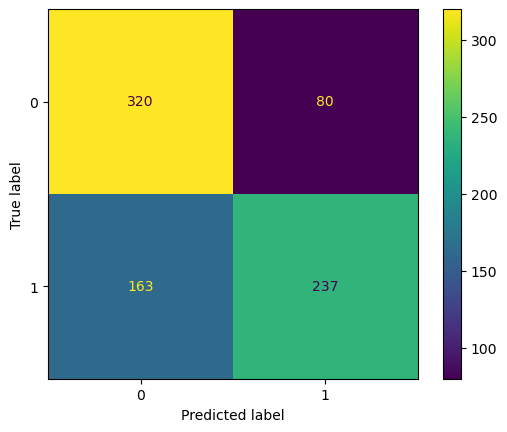

In [12]:
# Metrics for MLP classifier

target_predicted = mlp_pipe.predict(data_test)

cm = confusion_matrix(target_test, target_predicted)
acc = accuracy_score(target_test, target_predicted)
mcc = matthews_corrcoef(target_test, target_predicted)

ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=mlp_pipe.classes_,
    ).plot()

print("Metrics for MLP classifier:")
print(f"{acc = }\n{mcc = }")


In [13]:
mlp_score = mlp_pipe.score(data_test, target_test)
print(f"{mlp_score = }")

lstm_score = lstm_pipe.score(data_test, target_test)
print(f"{lstm_score = }")


mlp_score = 0.69625
lstm_score = 0.7725


# GroupKFold cross-validation 
(doing it right)

In [14]:
cv = GroupKFold(n_splits=5)
test_score = cross_val_score(
    mlp_pipe,
    data, target,
    groups=groups,
    cv=cv,
    n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")


The average accuracy is 0.786 ± 0.037


In [15]:
cv = GroupKFold()
test_score = cross_val_score(
    lstm_pipe,
    data, 
    target, 
    groups=groups,
    cv=cv, 
    n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")


The average accuracy is 0.767 ± 0.044


# Grid search
use randomizedgridsearch: https://scikit-learn.org/stable/modules/grid_search.html#grid-search

# More stuff (WIP)

In [ ]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

In [ ]:
# # with grid search
# from sklearn.model_selection import GridSearchCV

# # deactivate skorch-internal train-valid split and verbose logging
# net.set_params(train_split=False, verbose=0)
# params = {
#     'lr': [0.01, 0.02],
#     'max_epochs': [10, 20],
#     'module__num_units': [100, 1000],
# }
# gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

# gs.fit(data, target)
# print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

# Test set

In [ ]:
# Load data
data_test = np.load(Path(r"data/data_test.npy"))
target_test = np.load(Path(r"data/target_test.npy"))

# Scale data
data_test = StandardScaler3D().fit_transform(data_test)

# Reshape X to 1-D for MLP
data_test = np.reshape(data_test, (
    data_test.shape[0],
    data_test.shape[2]*data_test.shape[1]
), order="F")

plt.plot(data_test[142]);
print(f"{data_test.shape = }")

## Sklearn implementation


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GroupKFold

model = MLPClassifier(
    random_state=1, 
    max_iter=500, 
    early_stopping=True)

cv = GroupKFold()
test_score = cross_val_score(model, data, target, groups=groups, cv=cv,
                             n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")

In [ ]:
all_scores = pd.DataFrame(
    [test_score],
    index=["KFold with groups"],
).T

all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Accuracy score")
_ = plt.title("Distribution of the test scores")

# Tests

In [ ]:
# TODO: compare 3d standardization with old version, which was done by hand

In [ ]:
# test for tranform_to_1d

# Reshape X to 1-D for MLP
data = np.reshape(data, (
    data.shape[0],
    data.shape[2]*data.shape[1]
), order="F")

plt.plot(data[142]);
print(f"{data.shape = }")

In [14]:
from sklearn.model_selection import GroupKFold
X = range(100)
y = target[:100]
groups_ = groups[:1000:10]
gkf = GroupKFold(n_splits=6)
for train, test in gkf.split(X, y, groups=groups_):
    print("%s %s" % (train, test))
    print(f"{train.shape = }\n{test.shape = }")

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94 95] [ 0  1  2  3 20 21 22 23 48 49 50 51 68 69 70 71 96 97 98 99]
train.shape = (80,)
test.shape = (20,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 96 97 98 99] [24 25 26 27 44 45 46 47 72 73 74 75 92 93 94 95]
train.shape = (84,)
test.shape = (16,)
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94 95 96 97 98 99] [ 4  5  6  7 28 29 30 31 52 53 54 55 76 77 78 79]
t